<a href="https://colab.research.google.com/github/Rionma8/MVA_MGI_Project/blob/main/CLD_SGM_U_net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


#CLD Score-based Generative modeling with the U-net architecture


In [ ]:
! pip install configargparse
! pip install torchdiffeq
! pip install ninja

In [5]:
import importlib
import utils as ut
importlib.reload(ut)
import sde_lib as sl
importlib.reload(sl)
import sampling as sampl
importlib.reload(sampl)
import loss as lo
importlib.reload(lo)


import json
from torchvision.utils import make_grid
import configargparse
import gc
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import functools
from torch.optim import Adam
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
import tqdm

device = 'cuda'

## Parameters (in the MNIST_config.py file)

In [6]:
p = configargparse.ArgParser()
p.add('-mnist', is_config_file=True, default='MNIST_config.txt')

# Data
p.add('--name')
p.add('--dataset')
p.add('--is_image', action='store_true')
p.add('--image_size', type=int)
p.add('--center_image', action='store_true')
p.add('--image_channels', type=int)

p.add('--loss_eps', type=float)
p.add('--sde')
p.add('--beta_type')
# Linear beta params
p.add('--beta0', type=float)
p.add('--beta1', type=float)
# ULD params
p.add('--m_inv', type=float)
p.add('--gamma', type=float)
p.add('--numerical_eps', type=float)
p.add('--denoising', action='store_true')
p.add('--mixed_score', action='store_true')
p.add('--weighting', choices=['likelihood', 'reweightedv1', 'reweightedv2'])

p.add('--nonlinearity')
p.add('--n_channels', type=int)
p.add('--ch_mult')
p.add('--n_resblocks', type=int)
p.add('--attn_resolutions')
p.add('--dropout', type=float)
p.add('--resamp_with_conv', action='store_true')
p.add('--use_fir', action='store_true')
p.add('--fir_kernel')
p.add('--skip_rescale', action='store_true')
p.add('--resblock_type')
p.add('--progressive')
p.add('--progressive_input')
p.add('--embedding_type', choices=['fourier', 'positional'])
p.add('--init_scale', type=float)
p.add('--progressive_combine')
p.add('--fourier_scale', type=int)

# ODE 
p.add('--sampling_solver_options', type=json.loads, default={'solver': 'RK45'})
p.add('--sampling_solver', default='scipy_solver')
p.add('--sampling_rtol', type=float, default=1e-5)
p.add('--sampling_atol', type=float, default=1e-5)


p.add('--sampling_eps', type=float)
p.add('--cld_objective', choices=['dsm', 'hsm'], default='hsm')

p.add('--distributed', action='store_false')
p.add('--training_batch_size', type=int)
p.add('--testing_batch_size', type=int)
p.add('--sampling_batch_size', type=int)
p.add('--sscs_num_stab', type=float, default=1e-5)

batch_size = 16
config = p.parse_args(args=['--distributed',
                            '--training_batch_size', str(batch_size),
                            '--testing_batch_size', str(batch_size),
                            '--sampling_batch_size', str(batch_size)])

config.device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

## Define the $\beta(t)$ and $\mathcal{B}(t)$ functions (utils.py) + the stochastic differential equation (sde_lib.py)

In [7]:
beta_fn = ut.build_beta_fn(config)
beta_int_fn = ut.build_beta_fn(config)
sde = sl.CLD(config, beta_fn, beta_int_fn)

## Define the loss (loss.py file)

In [8]:
loss_CLD = lo.get_loss_fn(sde,True,config)

## Define the architecture of the network used to approximate the score function (U-net)

In [9]:
class GaussianFourierProjection(nn.Module):
  """Gaussian random features for encoding time steps."""  
  def __init__(self, embed_dim, scale=30.):
    super().__init__()
    # Randomly sample weights during initialization. These weights are fixed 
    # during optimization and are not trainable.
    self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)
  def forward(self, x):
    x_proj = x[:, None] * self.W[None, :] * 2 * np.pi
    return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)


class Dense(nn.Module):
  """A fully connected layer that reshapes outputs to feature maps."""
  def __init__(self, input_dim, output_dim):
    super().__init__()
    self.dense = nn.Linear(input_dim, output_dim)
  def forward(self, x):
    return self.dense(x)[..., None, None]


class ScoreNet(nn.Module):
  """A time-dependent score-based model built upon U-Net architecture."""

  def __init__(self, channels=[64, 64, 128, 256], embed_dim=256):
    """Initialize a time-dependent score-based network.

    Args:
      marginal_prob_std: A function that takes time t and gives the standard
        deviation of the perturbation kernel p_{0t}(x(t) | x(0)).
      channels: The number of channels for feature maps of each resolution.
      embed_dim: The dimensionality of Gaussian random feature embeddings.
    """
    super().__init__()
    # Gaussian random feature embedding layer for time
    self.embed = nn.Sequential(GaussianFourierProjection(embed_dim=embed_dim),
         nn.Linear(embed_dim, embed_dim))
    # Encoding layers where the resolution decreases
    self.conv1 = nn.Conv2d(2, channels[0], 3, stride=1, bias=False)
    self.dense1 = Dense(embed_dim, channels[0])
    self.gnorm1 = nn.GroupNorm(4, num_channels=channels[0])

    self.conv2 = nn.Conv2d(channels[0], channels[1], 3, stride=2, bias=False)
    self.dense2 = Dense(embed_dim, channels[1])
    self.gnorm2 = nn.GroupNorm(32, num_channels=channels[1])

    self.conv3 = nn.Conv2d(channels[1], channels[2], 3, stride=2, bias=False)
    self.dense3 = Dense(embed_dim, channels[2])
    self.gnorm3 = nn.GroupNorm(32, num_channels=channels[2])

    self.conv4 = nn.Conv2d(channels[2], channels[3], 3, stride=2, bias=False)
    self.dense4 = Dense(embed_dim, channels[3])
    self.gnorm4 = nn.GroupNorm(32, num_channels=channels[3])    

    # Decoding layers where the resolution increases
    self.tconv4 = nn.ConvTranspose2d(channels[3], channels[2], 3, stride=2, bias=False)
    self.dense5 = Dense(embed_dim, channels[2])
    self.tgnorm4 = nn.GroupNorm(32, num_channels=channels[2])

    self.tconv3 = nn.ConvTranspose2d(channels[2] + channels[2], channels[1], 3, stride=2, bias=False, output_padding=1)    
    self.dense6 = Dense(embed_dim, channels[1])
    self.tgnorm3 = nn.GroupNorm(32, num_channels=channels[1])

    self.tconv2 = nn.ConvTranspose2d(channels[1] + channels[1], channels[0], 3, stride=2, bias=False, output_padding=1)    
    self.dense7 = Dense(embed_dim, channels[0])
    self.tgnorm2 = nn.GroupNorm(32, num_channels=channels[0])

    self.tconv1 = nn.ConvTranspose2d(channels[0] + channels[0], 1, 3, stride=1)
    
    # The swish activation function
    self.act = lambda x: x * torch.sigmoid(x)
    #self.marginal_prob_std = marginal_prob_std
  
  def forward(self, x, t): 
    # Obtain the Gaussian random feature embedding for t   
    embed = self.act(self.embed(t))    
    # Encoding path
    h1 = self.conv1(x)    
    ## Incorporate information from t
    h1 += self.dense1(embed)
    ## Group normalization
    h1 = self.gnorm1(h1)
    h1 = self.act(h1) #sigmoid

    h2 = self.conv2(h1)
    h2 += self.dense2(embed)
    h2 = self.gnorm2(h2)
    h2 = self.act(h2)

    h3 = self.conv3(h2)
    h3 += self.dense3(embed)
    h3 = self.gnorm3(h3)
    h3 = self.act(h3)

    h4 = self.conv4(h3)
    h4 += self.dense4(embed)
    h4 = self.gnorm4(h4)
    h4 = self.act(h4)

    # Decoding path
    h = self.tconv4(h4)
    ## Skip connection from the encoding path
    h += self.dense5(embed)
    h = self.tgnorm4(h)
    h = self.act(h)

    h = self.tconv3(torch.cat([h, h3], dim=1))
    h += self.dense6(embed)
    h = self.tgnorm3(h)
    h = self.act(h)

    h = self.tconv2(torch.cat([h, h2], dim=1))
    h += self.dense7(embed)
    h = self.tgnorm2(h)
    h = self.act(h)

    h = self.tconv1(torch.cat([h, h1], dim=1))

    # Normalize output
    #h = h / self.marginal_prob_std(t)[:, None, None, None]
    return h

## Download the MNIST database

In [ ]:
import functools
from torch.optim import Adam
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
import tqdm

score_model = torch.nn.DataParallel(ScoreNet())
score_model = score_model.to(device).double()

n_epochs = 5
## size of a mini-batch
batch_size =  32
## learning rate
lr=2e-4

dataset = MNIST('.', train=True, transform=transforms.ToTensor(), download=True)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=4)

optimizer = Adam(score_model.parameters(), lr=lr)

## Training of the network on the database

  0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


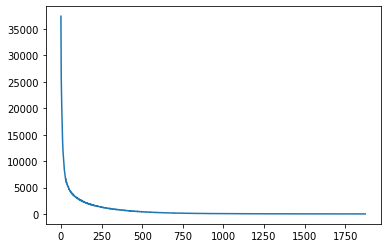

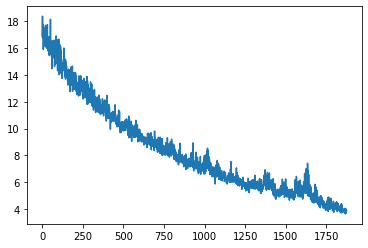

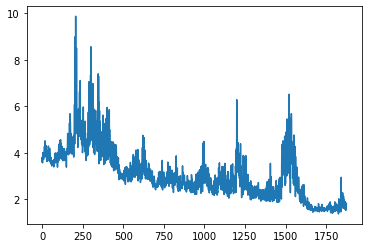

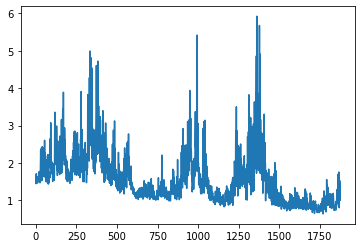

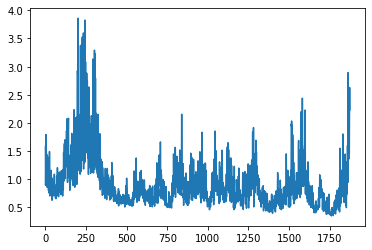

In [12]:
#Training
tqdm_epoch = tqdm.notebook.trange(n_epochs)
for epoch in tqdm_epoch:
  total_loss = []
  avg_loss = 0.
  num_items = 0
  for x, y in data_loader:
    x = x.to(device)    
    loss = loss_CLD(score_model, x)
    loss = torch.mean(loss) 
    total_loss.append(loss.detach().cpu().numpy())
    optimizer.zero_grad()
    loss.backward()    
    optimizer.step()
    avg_loss += loss.item() * x.shape[0]
    num_items += x.shape[0]
  plt.plot(total_loss)
  plt.show()
  # Print the averaged training loss so far.
  tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))
  # Update the checkpoint after each epoch of training.
  torch.save(score_model.state_dict(), 'ckpt.pth')

## Sampling with Euler-Maruyama method

In [13]:
config.sampling_method = 'em'

config.n_discrete_steps = 500

config.striding = 'linear'

config.sampling_eps = 1e-3
config.denoising = True
config.mixed_score = False

sampling_shape = (config.sampling_batch_size, 1, 28, 28)

sampler = sampl.get_sampling_fn(config, sde, sampling_shape, config.sampling_eps)


x, _, _ = sampler(score_model)

## Plot the results

In [14]:
inverse_scaler = ut.get_data_inverse_scaler(config)

def plot_samples(x):
    nrow = int(np.sqrt(x.shape[0]))
    image_grid = make_grid(inverse_scaler(x).clamp(0., 1.), nrow)
    plt.axis('off')
    plt.imshow(image_grid.permute(1, 2, 0).cpu())

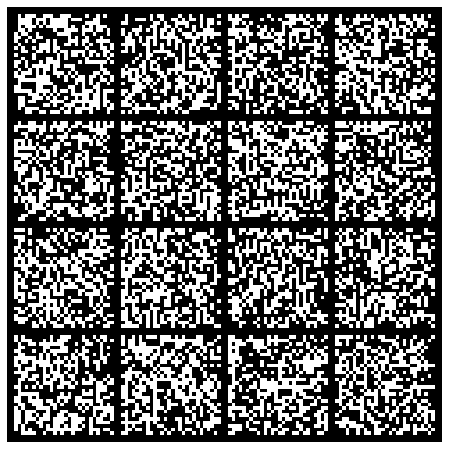

In [15]:
from torchvision.utils import make_grid
plt.figure(figsize=(8, 8))
plot_samples(x)

gc.collect()
if torch.cuda.is_available():
  torch.cuda.empty_cache()

# Our implementation of the loss (does not work to train the network)

In [ ]:
def compute_sigma(t):

  ####### PARAMETERS #######
  M = 1/config.m_inv
  tau = np.sqrt(4*M)
  beta = config.beta0
  alpha = config.gamma
  ##########################

  # computation of \sigma_t HSM case: 
  sigma_0_xx = 0
  sigma_0_vv = alpha * M
  beta_t = beta * t
  beta_t = np.expand_dims(beta_t, axis=( 1, 2, 3))

  sigma_t_xx = sigma_0_xx + np.exp(4 * beta_t * 1/tau) - 1 + 4 * beta_t * 1/tau * (sigma_0_xx - 1) + 4 * beta_t**2 * (1/tau)**2 * (sigma_0_xx - 2) + 16 * beta_t**2 * (1/tau)**4 * sigma_0_vv

  
  sigma_t_xv = - beta_t * sigma_0_xx + 4 * beta_t * (1/tau)**2 * sigma_0_vv - 2 * beta_t**2*(1/tau)*(sigma_0_xx - 2) - 8*beta_t**2 * (1/tau)**3 * sigma_0_vv
  sigma_t_vv = tau**2/4*(np.exp(4 * beta_t * 1/tau) - 1) + beta_t * tau + sigma_0_vv* (1 + 4 * beta_t**2 * (1/tau)**2 - 4 * beta_t * 1/tau) + beta_t**2*(sigma_0_xx - 2)

  return sigma_t_xx*np.exp(-4*beta_t/tau), sigma_t_xv*np.exp(-4*beta_t/tau), sigma_t_vv*np.exp(-4*beta_t/tau)

def compute_mu(t,x_0,v_0):

  ###### PARAMETERS #######
  M = 1/config.m_inv
  beta = config.beta0
  tau = np.sqrt(4*M)
  ########################

  # computation of mu_t HSM case
  beta_t = beta * t
  beta_t = np.expand_dims(beta_t, axis=( 1, 2, 3))
  beta_t = torch.tensor(beta_t, device=device)
  #print(torch.mul(beta_t,v_0))
  mu_t_x = torch.mul((2 * 1/tau * torch.mul(beta_t,x_0) + 4 * (1/tau)**2 * torch.mul(beta_t,v_0) + x_0) , torch.exp(-2 * 1/tau * beta_t))
  mu_t_v = torch.mul((-torch.mul(beta_t,x_0) -2 * (1/tau) * torch.mul(beta_t,v_0) + v_0) , torch.exp(-2 * 1/tau * beta_t))
  return mu_t_x, mu_t_v

In [ ]:
def loss_fn_bis(model, x, eps=1e-5):

  M = 1/config.m_inv
  tau = np.sqrt(4*M)

  x0 = x
  v0 = torch.zeros(x.shape)
  v0 = torch.tensor(v0, device=device)
  d = x.shape[2]
  random_t = np.random.random(x.shape[0]) * (1. - eps) + eps 
  eps_num = 10**(-9)

  beta_t = config.beta0 * random_t
  beta_t = np.expand_dims(beta_t, axis=( 1, 2))

  
  sigma_t_xx, sigma_t_xv, sigma_t_vv = compute_sigma(random_t)
  #print(np.amax(sigma_t_xx),np.amax(sigma_t_xv),np.amax(sigma_t_vv))
  sigma_t = np.array([np.array([[sigma_t_xx[i,0,0,0], sigma_t_xv[i,0,0,0]], [sigma_t_xv[i,0,0,0], sigma_t_vv[i,0,0,0]]]) for i in range(len(sigma_t_xx))])

  l_t = [np.linalg.cholesky(sigma_t[i]+eps_num*np.eye(2)) for i in range(len(sigma_t))]# voir s'il existe une forumule 
  l_t = np.array(l_t)
  mu_t_x , mu_t_v = compute_mu(random_t,x0,v0)

  z_x = torch.randn_like(x)
  z_v = torch.randn_like(x)
  z_x = torch.tensor(z_x, device=device)
  z_v = torch.tensor(z_v, device=device)
  ell_t = np.array([np.sqrt(sigma_t_xx[i]/(sigma_t_xx[i] * sigma_t_vv[i] - sigma_t_xv[i]**2)) for i in range(len(sigma_t_xx))])
  ell_t = torch.tensor(ell_t, device=device)
  #print(z.shape, ell_t.shape)
  l_t = torch.tensor(l_t, device=device)
  grad = - torch.mul(ell_t,z_v) ### check that x is a vector and not an image (matrix)
  u_t_x = mu_t_x + torch.mul(l_t[:,0,0].unsqueeze(1).unsqueeze(1).unsqueeze(1),z_x)
  u_t_v = mu_t_v + torch.mul(l_t[:,0,1].unsqueeze(1).unsqueeze(1).unsqueeze(1),z_x) + torch.mul(l_t[:,1,1].unsqueeze(1).unsqueeze(1).unsqueeze(1),z_v)
                                 
  #u_t_ = torch.cat((u_t_x , u_t_v),dim = 2) 
  u_t_ = torch.cat((u_t_x,u_t_v),dim =1)
  #complete = torch.zeros_like(u_t_)
  #u_t = torch.cat((u_t_ , complete),dim = 3) 
  random_t = torch.tensor(random_t, device=device)
  score = model(u_t_.double()[:,:,:,:], random_t.double())
  loss = torch.mean(torch.sum((score - grad)**2, dim=(1,2,3)))
  return loss